# KelvinSphere Benchmark
Based on DM's notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from alma import *
from almapyc import *
import mpmath as mp

In [2]:
# Initialize
ndigits = 128
Gnwt, iota = initialize(ndigits)

# Define the KS model
a   = 6371e3
rho = 5.514e3
mu  = 1.46e11
eta = 1e21

r_in = ['3480e3', '6371e3']
rho_in = [ '5.514e3', '5.514e3' ]
mu_in = [ '1.46e11', '1.46e11' ]
eta_in = [ '1e21', '1e21' ]
rheology = ['maxwell', 'maxwell']
params = [[0,0], [0,0]]

model_params = build_model(r_in, rho_in, mu_in, eta_in, rheology, params, ndigits=128, verbose=True)

> Initializing
  >> Setting precision: 128
> Building model
  >> Parsing Rheology
  >> Computing mass of the planet
  >> Computing gravity at the interface boundaries
  >> Normalizing model parameters


In [3]:
# Set up ALMA parameters
n = 2
loadtype='tidal'
loadfcn='step'
tau=0
order=8

t = np.logspace(-5,5,101)

In [4]:
# Tidal LNs, their derivatives, and frequency dependent LNs
output='real'
h2, l2, k2 = love_numbers([ n ], t, loadtype, loadfcn, tau, model_params, output, order, verbose=True)

output='rate'
dh2, dl2, dk2 = love_numbers([ n ], t, loadtype, loadfcn, tau, model_params, output, order, verbose=True)

output='complex'
hc2, lc2, kc2 = love_numbers([ n ], t, loadtype, loadfcn, tau, model_params, output, order, verbose=True)

> Computing Salzer weights
Harmonic degree n = 2 (3.4298145160000786 s)
> Computing Salzer weights
Harmonic degree n = 2 (3.4527417099998274 s)
Harmonic degree n = 2 (0.33882899100080976 s)


In [5]:
# analytical results

t_ref = np.copy(t)
kyr2s = 1000 * 365.25 * 24 * 3600

pi = np.pi
G  = 6.67e-11
g  = G * (4/3)*pi*a*rho

gamma = (19/2) * mu/(rho*g*a)

tau  = eta/mu
taup = (1+gamma)*tau

hf = 5/2
kf = 3/2

ln_ref = 1 / (1+gamma) * ( 1 + gamma * (1-np.exp(-t_ref*kyr2s/taup)) )

h2_ref = hf * ln_ref
k2_ref = kf * ln_ref

dln_ref = 1 / (1+gamma) * (1/tau - 1/taup) * np.exp(-t_ref*kyr2s/taup)

dh2_ref = hf * dln_ref * kyr2s
dk2_ref = kf * dln_ref * kyr2s
gamma
omega = 2*pi/(t_ref*kyr2s)
phi_ref = np.arctan( (gamma*omega*tau) / (1+omega**2*tau*taup) )
q_ref = np.sqrt( 1 + (1/gamma**2) * (omega*taup + 1/(omega*tau))**2 )

lnr_ref = 1/(1+gamma) * (1 + gamma/(1+(omega*taup)**2))
lni_ref = - 1/(1+gamma) * gamma * (omega*taup) / (1+(omega*taup)**2)

h2r_ref = hf * lnr_ref
h2i_ref = hf * lni_ref

k2r_ref = kf * lnr_ref
k2i_ref = kf * lni_ref

(0.0, 2.5)

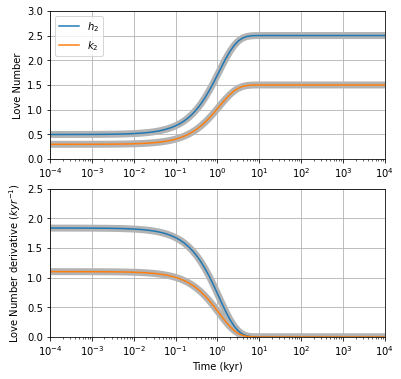

In [6]:
# Plot LNs vs time and their derivatives for a stepwise tidal load
# and compare them with reference LNs from analytical formulas
# for the Kelvin Sphere

c_ref=[0.7,0.7,0.7]
lw_ref=7

fig, (ax1, ax2) = plt.subplots(2, figsize=(6,6))

ax1.semilogx(t_ref, h2_ref, color=c_ref, linewidth=lw_ref)
ax1.semilogx(t_ref, k2_ref, color=c_ref, linewidth=lw_ref)
ax1.semilogx(t, h2[0,:], label='$h_2$')
ax1.semilogx(t, k2[0,:], label='$k_2$')
ax1.set_xlim(1e-4, 1e4)
ax1.grid()
ax1.legend()
ax1.set_ylabel('Love Number')
ax1.set_ylim(0,3)

ax2.semilogx(t_ref, dh2_ref, color=c_ref, linewidth=lw_ref)
ax2.semilogx(t_ref, dk2_ref, color=c_ref, linewidth=lw_ref)
ax2.semilogx(t, dh2[0,:])
ax2.semilogx(t, dk2[0,:])
ax2.set_xlim(1e-4, 1e4)
ax2.grid()
ax2.set_ylabel('Love Number derivative ($kyr^{-1}$)')
ax2.set_xlabel('Time (kyr)')
ax2.set_ylim(0,2.5)

Text(0.5, 0, 'Period (kyr)')

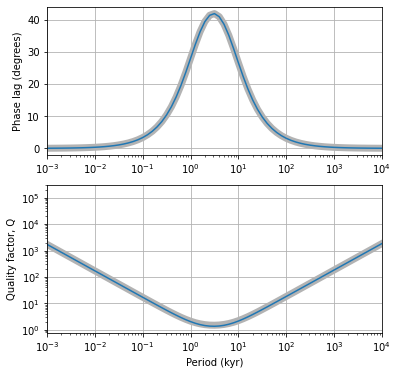

In [7]:
# Plot phase lag and quality factor for a periodic tidal load as a function of the
# forcing period and compare them with reference LNs from analytical formulas
# for the Kelvin Sphere

phi = -np.arctan( np.imag(hc2[0,:]) / np.real(hc2[0,:]) )
q   = 1/phi

r2d = 180 / np.pi

fig, (ax1, ax2) = plt.subplots(2, figsize=(6,6))

ax1.semilogx(t_ref, phi_ref*r2d, color=c_ref, linewidth=lw_ref )
ax1.semilogx(t, phi*r2d )
ax1.set_xlim(1e-3, 1e4)
ax1.grid()
ax1.set_ylabel('Phase lag (degrees)')

ax2.semilogx(t_ref, q_ref, color=c_ref, linewidth=lw_ref )
ax2.loglog(t, q)
ax2.set_xlim(1e-3, 1e4)
ax2.grid()
ax2.set_ylabel('Quality factor, Q')
ax2.set_xlabel('Period (kyr)')

Text(0, 0.5, 'Imaginary part')

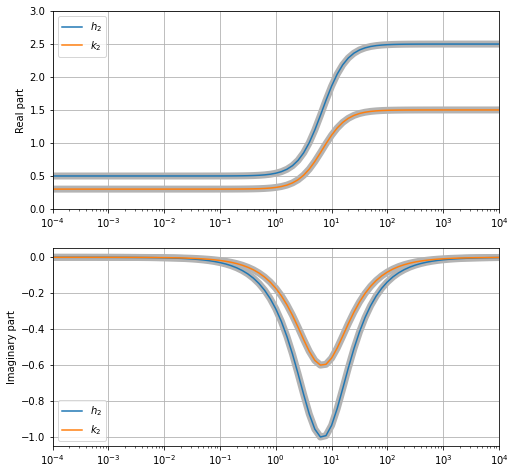

In [8]:
# Plot Re(LN) and Im(LN) for a periodic tidal load as a function of the
# forcing period and compare them with reference LNs from analytical formulas
# for the Kelvin Sphere

fig, (ax1, ax2) = plt.subplots(2, figsize=(8,8))

ax1.semilogx(t_ref, h2r_ref, color=c_ref, linewidth=lw_ref)
ax1.semilogx(t_ref, k2r_ref, color=c_ref, linewidth=lw_ref)
ax1.semilogx(t, np.real(hc2[0,:]), label='$h_2$')
ax1.semilogx(t, np.real(kc2[0,:]), label='$k_2$')
ax1.set_xlim(1e-4, 1e4)
ax1.grid()
ax1.legend()
ax1.set_ylabel('Real part')
ax1.set_ylim(0,3)

ax2.semilogx(t_ref, h2i_ref, color=c_ref, linewidth=lw_ref)
ax2.semilogx(t_ref, k2i_ref, color=c_ref, linewidth=lw_ref)
ax2.semilogx(t, np.imag(hc2[0,:]), label='$h_2$')
ax2.semilogx(t, np.imag(kc2[0,:]), label='$k_2$')
ax2.set_xlim(1e-4, 1e4)
ax2.grid()
ax2.legend()
ax2.set_ylabel('Imaginary part')
#ax2.set_ylim(0,3)